In [1]:
import pickle
import torch
import pandas as pd

def read_instance(path):
    with open(path, 'rb') as handle:
        b = pickle.load(handle)
    out_df = pd.DataFrame(b['lb'].cpu()).add_prefix("output_margin_")
    diff = b['x_U'].squeeze()[:,:19].cpu() - b['x_L'].squeeze()[:,:19].cpu()
    diff_df = pd.DataFrame(diff).add_prefix("diff_")
    repetition_df = pd.DataFrame(b['rep'].cpu(), columns=["repetition"])
    pruned_df = pd.DataFrame(1 - (b['lb_plain'] <= 0).all(1).cpu().type(torch.uint8), columns=["pruned_plain"])
    pruned_alpha_df = pd.DataFrame(1 - (b['lb'] <= 0).all(1).cpu().type(torch.uint8), columns=["pruned_alpha"])
    domain_df = pd.concat([out_df, diff_df, repetition_df, pruned_df, pruned_alpha_df], axis=1, join='inner')
    
    return domain_df


In [4]:
path = "/home/mzi/rl-verif/alpha-beta-CROWN/complete_verifier/input_split/pickled/alpha_partition20_iteration10_in19_lower04_upper06_eps001_out15_0_14/{}.pickle"


In [24]:
pdf = read_instance(path=path.format(4))
plain_prune_ratio = pdf[(pdf['pruned_plain'] == 1)].size / pdf.size
alpha_gain = pdf[(pdf['pruned_alpha'] == 1) & (pdf['pruned_plain'] == 0)].size / pdf.size
alpha_loss = pdf[(pdf['pruned_alpha'] == 0) & (pdf['pruned_plain'] == 1)].size / pdf.size
print(plain_prune_ratio, alpha_gain, alpha_loss)

0.04073486328125 0.0076416015625 0.033984375


In [23]:
pdf.size, pdf[(pdf['pruned_plain'] == 1)].size

(4096000, 166850)

In [62]:
path = "/home/mzi/sys-rl-verif/alpha-beta-CROWN/complete_verifier/input_split/pickled/take_2_alpha_alternate_90_2_10_10_in19_lower04_upper06_eps001_out15_0_14/{}.pickle"
pdf_all = read_instance(path=path.format(0))[['pruned_plain', 'pruned_alpha', 'repetition']]
domains_count = 1
plain_prune_ratio_list = []
alpha_gain_list = []
alpha_loss_list = []

for i in range(1, 1700):
    pdf = read_instance(path=path.format(i))[['pruned_plain', 'pruned_alpha', 'repetition']]
    pdf_all = pd.concat([pdf, pdf_all])
    # plain_prune_ratio = pdf[(pdf['pruned_plain'] == 1)].size / pdf.size
    # alpha_gain = pdf[(pdf['pruned_alpha'] == 1) & (pdf['pruned_plain'] == 0)].size / pdf.size
    # alpha_loss = pdf[(pdf['pruned_alpha'] == 0) & (pdf['pruned_plain'] == 1)].size / pdf.size
    # plain_prune_ratio_list.append(plain_prune_ratio)
    # alpha_gain_list.append(alpha_gain)
    # alpha_loss_list.append(alpha_loss)


<Axes: >

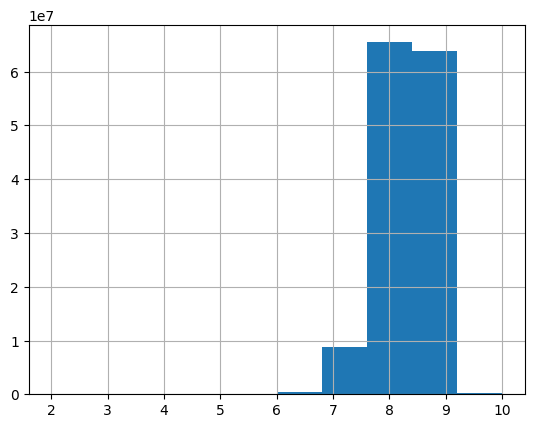

In [71]:
pdf_all['repetition'].hist()

<Axes: xlabel='repetition'>

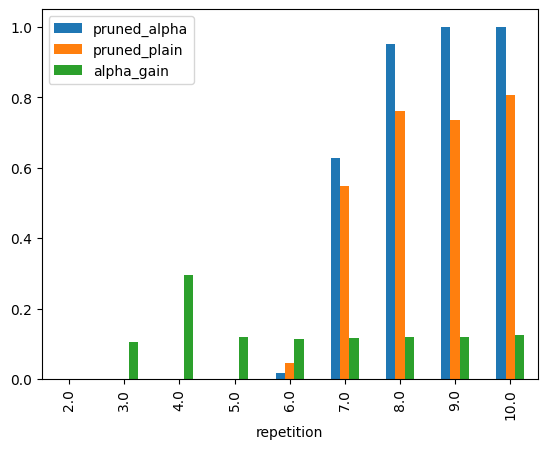

In [70]:
pdf_all['alpha_gain'] = ((pdf['pruned_alpha'] == 1) & (pdf['pruned_plain'] == 0))
pdf_all["alpha_gain"] = pdf_all["alpha_gain"].astype(int)
pdf_all[["repetition", "pruned_alpha", "pruned_plain", "alpha_gain"]].groupby("repetition").mean().plot.bar()

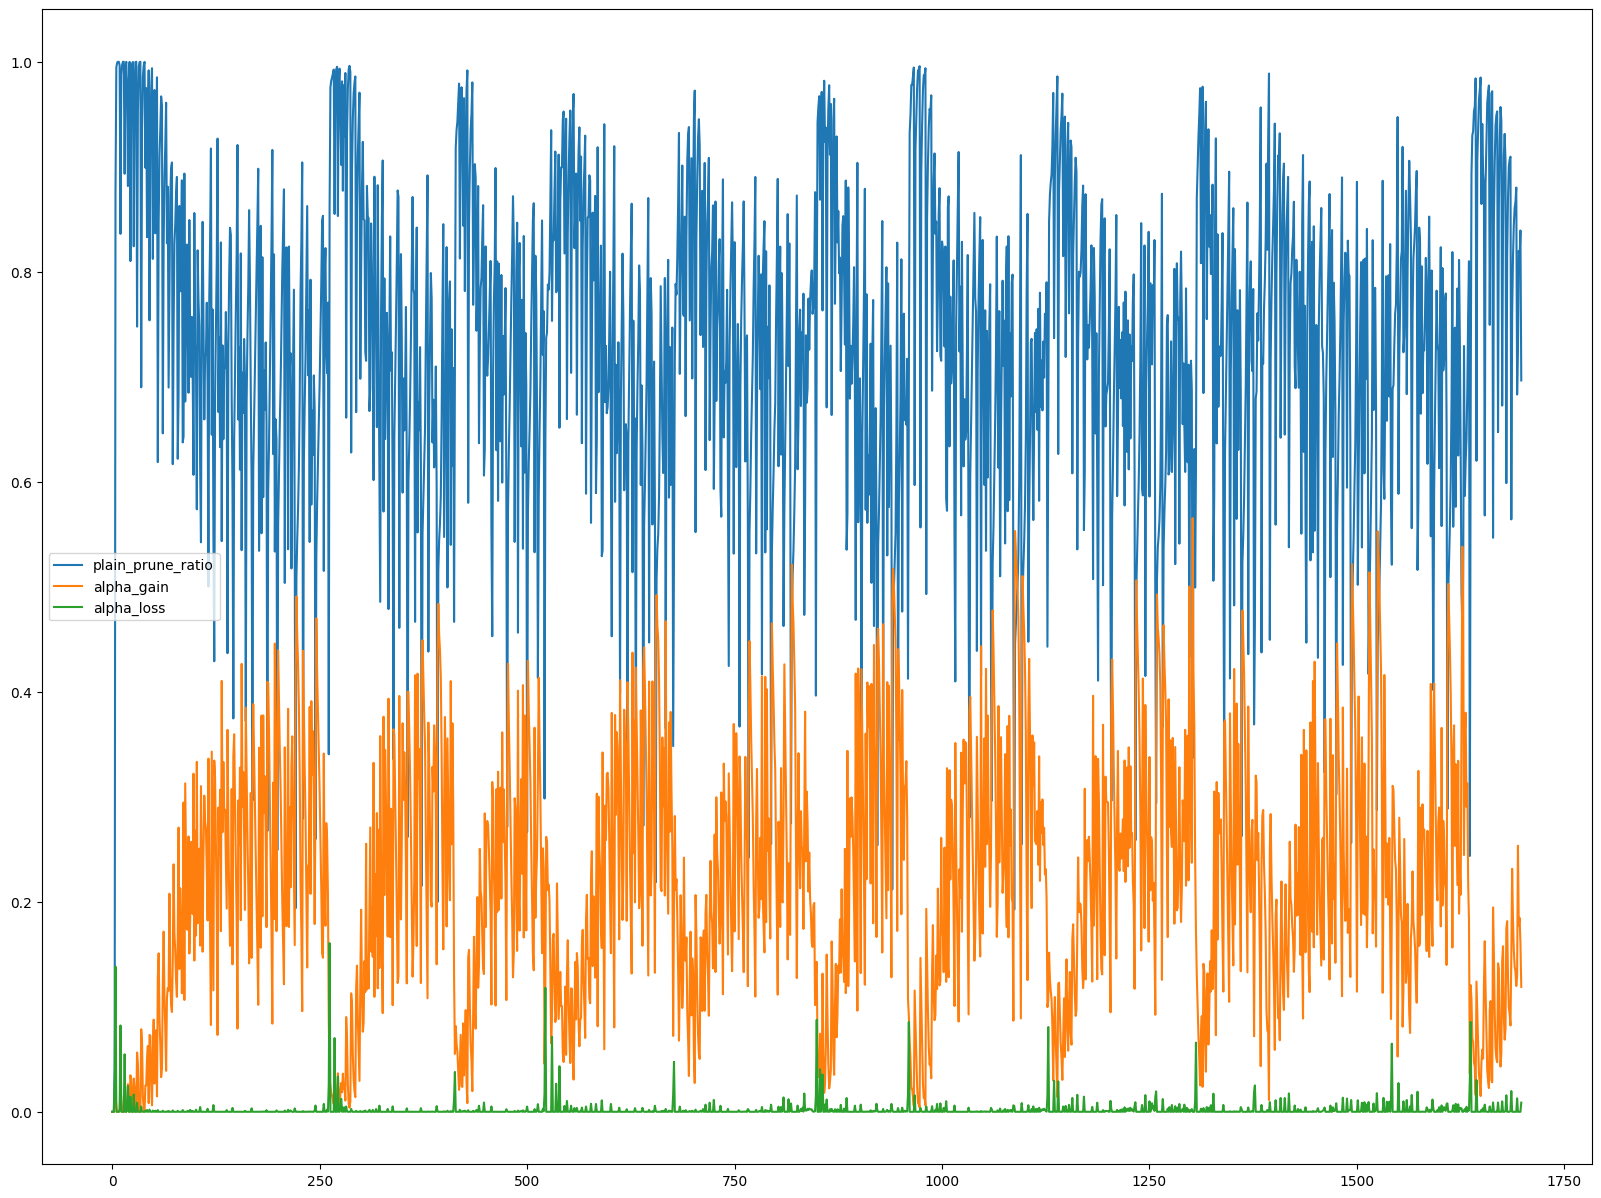

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
plt.plot(plain_prune_ratio_list, label="plain_prune_ratio")
plt.plot(alpha_gain_list, label="alpha_gain")
plt.plot(alpha_loss_list, label="alpha_loss")
plt.legend()
plt.show()